# Install Libs and Dependencies

In [ ]:
!pip install pennylane

     |████████████████████████████████| 800 kB 7.9 MB/s 
     |████████████████████████████████| 1.6 MB 22.0 MB/s 
     |████████████████████████████████| 7.8 MB 34.2 MB/s 
     |████████████████████████████████| 108 kB 45.2 MB/s 


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
from pennylane.templates.embeddings import AmplitudeEmbedding

from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load Data

In [ ]:
# Load train and test dataset
train_df_loc = Path( "mock_train_set.csv" )
test_df_loc  = Path( "mock_test_set.csv" )

train_df = pd.read_csv(train_df_loc)
test_df  = pd.read_csv(test_df_loc)

train_df = train_df.astype({"1":int, "2": int, "3": int, "4": int})
test_df  = test_df.astype( {"1":int, "2": int, "3": int, "4": int})
train_df

,0,1,2,3,4
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
...,...,...,...,...,...
295,1464.52,1000000,10000,45,1
296,3493.66,1000000,100000,85,1
297,4182.81,1,1,65,0
298,3113.75,10000,100,1,1


# EDA

In [ ]:
# Dataset statistics
train_df.describe()

,0,1,2,3,4
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,2630.877933,308630.410000,127187.050000,46.220000,0.476667
std,1416.096576,460586.067687,314218.134392,27.488488,0.500290
min,42.350000,1.000000,1.000000,1.000000,0.000000
25%,1408.067500,1.000000,10.000000,20.000000,0.000000
50%,2672.180000,1000.000000,1000.000000,50.000000,0.000000
75%,3895.692500,1000000.000000,10000.000000,70.000000,1.000000
max,4995.610000,1000000.000000,1000000.000000,90.000000,1.000000


In [ ]:
test_df.describe()

,0,1,2,3,4
count,120.000000,120.000000,120.00000,120.000000,120.000000
mean,2670.297000,301690.150000,185332.30000,47.700000,0.516667
std,1433.466373,459080.909348,377847.18346,27.204362,0.501817
min,31.710000,1.000000,1.00000,1.000000,0.000000
25%,1630.512500,1.000000,10.00000,25.000000,0.000000
50%,2610.575000,1000.000000,1000.00000,50.000000,1.000000
75%,3924.557500,1000000.000000,100000.00000,70.000000,1.000000
max,4913.340000,1000000.000000,1000000.00000,90.000000,1.000000


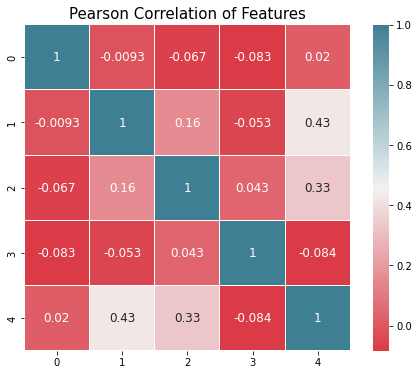

In [ ]:
# Feature Correlation Analysis
plt.figure(figsize=(8,6))
plt.title('Pearson Correlation of Features', size = 15)
colormap = sns.diverging_palette(10, 220, as_cmap = True)
sns.heatmap(train_df.corr(),
            cmap = colormap,
            square = True,
            annot = True,
            linewidths=0.1,vmax=1.0, linecolor='white',
            annot_kws={'fontsize':12 })
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


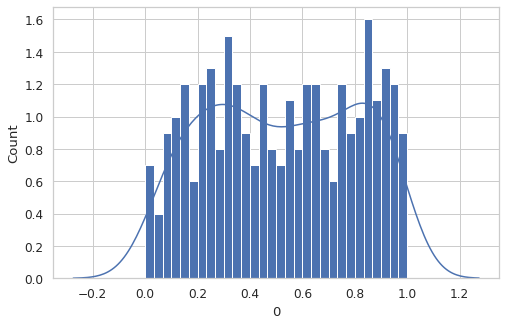

In [29]:
# Analyze data range of column_0
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    train_df['0'], norm_hist=False, kde=True, bins=30, hist_kws={"alpha": 1}
).set(xlabel='0', ylabel='Count');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


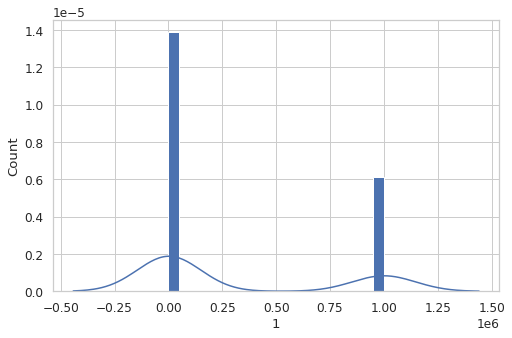

In [ ]:
# Analyze data range of column_1
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    train_df['1'], norm_hist=False, kde=True, bins=20, hist_kws={"alpha": 1}
).set(xlabel='1', ylabel='Count');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


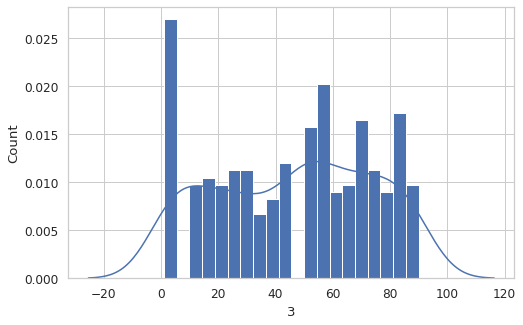

In [ ]:
# Analyze data range of column_3
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    train_df['3'], norm_hist=False, kde=True, bins=20, hist_kws={"alpha": 1}
).set(xlabel='3', ylabel='Count');

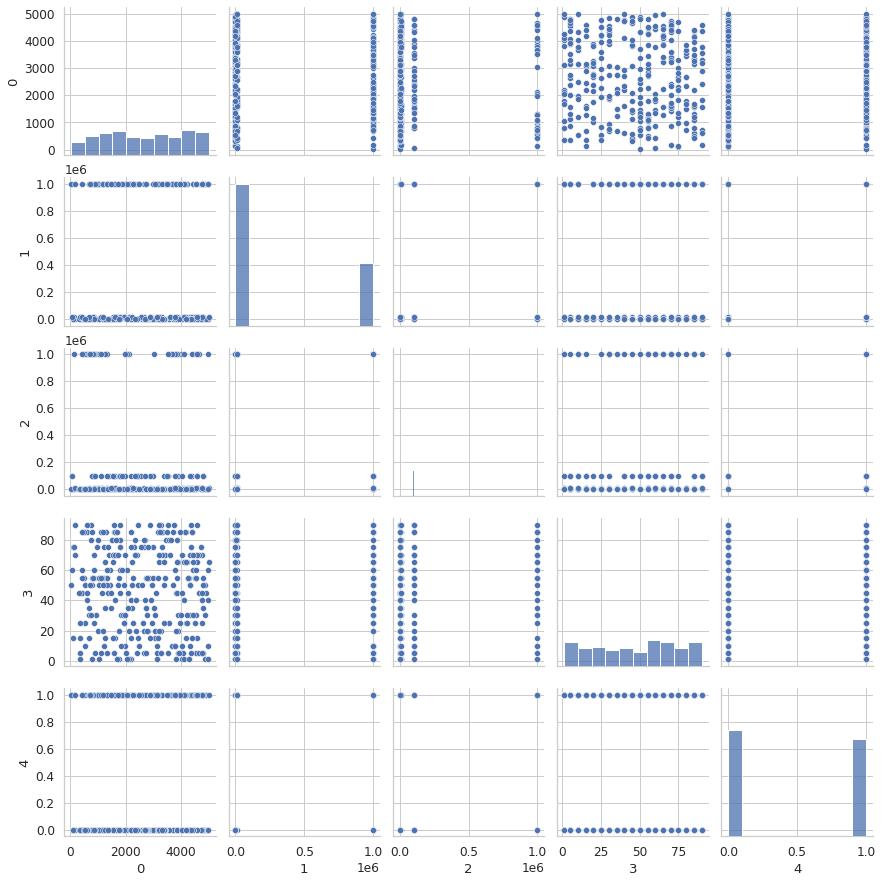

In [ ]:
# Visualize pairwise relationships in a dataset.
sns.pairplot(train_df)

# Feature Preprocessing

In [ ]:
# As values in Column_1 and Column_2 are discrete and in multiples of 10,
# log(base 10) transform is performed on Column_1 and Column_2 of train and test dataset
for i in range(1,3):
    train_df[str(i)] = np.log10(train_df[str(i)])
    test_df[str(i)]  = np.log10(test_df[str(i)])

In [ ]:
# Normalize columns in train and test datasets to fit in the range (0, 1)
scaler = MinMaxScaler(feature_range=(0,1)) #-np.pi, np.pi

for i in range(4):
    train_df[[str(i)]] = scaler.fit_transform( train_df[[str(i)]] )
    test_df[[str(i)]]  = scaler.transform( test_df[[str(i)]] )

In [ ]:
# Split train dataframe into the respective feature set and ground truth labels
X_training = train_df.iloc[:, :-1]    # select only the features by dropping the last column
Y_training = train_df.iloc[:, -1]     # select only the labels by selecting the last column

# Split test dataframe into the respective feature set and ground truth labels
X_test = test_df.iloc[:, :-1]    # select only the features by dropping the last column
Y_test = test_df.iloc[:, -1]     # select only the labels by selecting the last column

# Freeze the input training and test data
X_training = np.array(X_training, dtype=np.float32, requires_grad= False)
Y_training = np.array(Y_training, dtype=np.int32, requires_grad= False)

X_test  = np.array(X_test, dtype=np.float32, requires_grad= False)
Y_test  = np.array(Y_test, dtype=np.int32, requires_grad= False)

# Shift ground truth labels from {0, 1} to {-1, 1}
# to match PauliZ expectation values
Y_training = Y_training * 2 - np.ones(len(Y_training))
Y_test = Y_test * 2 - np.ones(len(Y_test))

In [ ]:
# Seed for reproducibility
np.random.seed(0)

# Split training data into train and validation sets
num_data = len(Y_training)
num_train = int(0.75 * num_data)

# Shuffle the training data and split into train and validation sets
index = np.random.permutation(range(num_data))

X_train = X_training[index[:num_train]]
Y_train = Y_training[index[:num_train]]

X_val = X_training[index[num_train:]]
Y_val = Y_training[index[num_train:]]

# Circuit Generation

In amplitude encoding, $2^n$ features are encoded into the amplitude vector of $n$ qubits.

In [ ]:
# Since there are 4 features, we require 2 qubits
num_qubits = 2

dev = qml.device('default.qubit', wires=num_qubits) #shots=1000

In [ ]:
# Define a Layer Template as a sequence of trainable gates.
# It is similar to the layers in a neural network.
def layer(W):
    # Single qubit rotations
    for i in range(num_qubits):
        qml.Rot(W[i,0], W[i,1], W[i,2], wires=i)
    
    # Entanglers between pairs of qubits
    for j in range(num_qubits-1):
        qml.CNOT(wires=[j, j+1])

    if num_qubits >= 2:
        qml.CNOT(wires=[num_qubits-1, 0])

In [ ]:
# Initialize a quantum device
@qml.qnode(dev)
def circuit(weights, x):
    
    #Prepare Quantum Dataset
    for i in range(2):
        qml.Hadamard(i)

    # Embed classical data as a quantum state in the Hilbert space
    AmplitudeEmbedding(features=x, wires=range(2), normalize=True)
    
    # Quantum Model
    for W in weights:
        layer(W)
    
    return qml.expval(qml.PauliZ(0))

In [ ]:
# Define squared loss as the loss function
def square_loss(labels, preds):
    loss = 0 
    for l,p in zip(labels, preds):
        loss += (l-p)**2
    loss = 2*loss / len(labels)
    return loss

# Define model accuracy for binary classification
def accuracy(labels, preds):
    correct_samples = 0
    for l,p in zip(labels, preds):
        if abs(l-p) < 1e-5:
            correct_samples += 1

    correct_samples /= len(labels)
    return correct_samples

In [ ]:
# Define Variational Quantum Classifier
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

# Define Cost function for the classifier
def cost(weights, bias, inputs, labels):    
    preds = [variational_classifier(weights, bias, x) for x in inputs]
    return square_loss(labels, preds)

In [ ]:
# Train the Qunatum classifier
def train_classifier(X_train, Y_train, batch_size=50, total_iterations=100,
                     learning_rate=0.01, weights=None, bias=None, num_train=None):

    opt = AdamOptimizer(stepsize = learning_rate)
    
    costs, train_accs, val_accs = [], [], []

    for iter in range(total_iterations):

        # Shuffle train data
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        excerpt = indices[:batch_size]

        # Extract slice of the shuffled data
        X_batch = X_train[excerpt]
        Y_batch = Y_train[excerpt]

        # Update trainable arguments with one step of the optimizer
        weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

        # Evaluate classifier output for train and validation set
        preds_train = [np.sign(variational_classifier(weights, bias, x)) for x in X_train ]
        preds_val =   [np.sign(variational_classifier(weights, bias, x)) for x in X_val ]
        
        # Calculate accuracy for train and validation set
        acc_train = accuracy(Y_train, preds_train)
        acc_val = accuracy(Y_val, preds_val)

        # Store model loss, training accuracy, and validation accuracy
        costs.append(cost(weights, bias, X_train, Y_train))
        train_accs.append(acc_train)
        val_accs.append(acc_val)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
            "".format(iter + 1, costs[-1], train_accs[-1], val_accs[-1])
        )

    # Evaluate model performance on test data
    preds_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]
    acc_test = accuracy(Y_test, preds_test)
    
    print(
            "Acc test: {:0.7f} "
            "".format(acc_test)
        )

    # Plot model training performance
    fig, ax1 = plt.subplots()
    iters = np.arange(0, total_iterations, 1)
    colors = ["tab:red", "tab:blue"]
    ax1.set_xlabel("Iterations", fontsize=17)
    ax1.set_ylabel("Cost", fontsize=17, color=colors[0])
    ax1.plot(iters, costs, color=colors[0], linewidth=2)
    ax1.tick_params(axis="y", labelsize=14, labelcolor=colors[0])

    ax2 = ax1.twinx()
    ax2.set_ylabel("Test Acc.", fontsize=17, color=colors[1])
    ax2.plot(iters, val_accs, color=colors[1], linewidth=2)

    ax2.tick_params(axis="x", labelsize=14)
    ax2.tick_params(axis="y", labelsize=14, labelcolor=colors[1])

    plt.grid(False)
    plt.tight_layout()
    plt.show()
        
    # Plot confusion matrix
    conf_mat = confusion_matrix(y_true = Y_test, y_pred = preds_test, labels=[-1,1])
    
    labels = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
    labels = np.asarray(labels).reshape(2,2)
    df_cm = pd.DataFrame(conf_mat, index=[0,1], columns=[0,1])
    plt.figure(figsize=(5,3))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot_kws={"size": 16}, annot=labels, fmt="", square=True, linewidths=0.5, cmap='rocket_r')
    plt.yticks( verticalalignment='center')
    plt.title('Confusion Matrix')
    plt.show()

[[[-0.01481986 -0.00104477  0.00022752]
  [-0.01324786 -0.0004604  -0.00219983]]] 0.0
Iter:     1 | Cost: 2.2273395 | Acc train: 0.5733333 | Acc validation: 0.5333333 
Iter:     2 | Cost: 2.0279227 | Acc train: 0.6355556 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.8842863 | Acc train: 0.6577778 | Acc validation: 0.6400000 
Iter:     4 | Cost: 1.7930005 | Acc train: 0.6444444 | Acc validation: 0.6933333 
Iter:     5 | Cost: 1.7289334 | Acc train: 0.6533333 | Acc validation: 0.6933333 
Iter:     6 | Cost: 1.6875529 | Acc train: 0.6755556 | Acc validation: 0.6533333 
Iter:     7 | Cost: 1.6644963 | Acc train: 0.6755556 | Acc validation: 0.6533333 
Iter:     8 | Cost: 1.6581002 | Acc train: 0.6533333 | Acc validation: 0.6400000 
Iter:     9 | Cost: 1.6644740 | Acc train: 0.6444444 | Acc validation: 0.6933333 
Iter:    10 | Cost: 1.6793082 | Acc train: 0.6444444 | Acc validation: 0.7066667 
Iter:    11 | Cost: 1.6956412 | Acc train: 0.6355556 | Acc validation: 0.6800000 
Iter:    12 

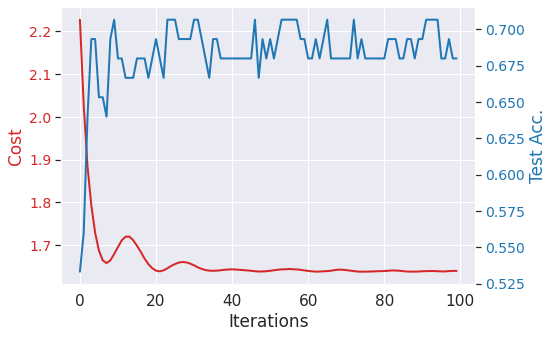

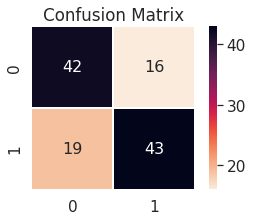

In [ ]:
# Initialize the weights and bias of the model layers
num_layers = 1
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

# train the classifier
train_classifier(X_train, Y_train, batch_size=170, total_iterations=100, learning_rate=0.1, weights=weights_init, bias=bias_init, num_train = num_train)

[[[-0.00112987  0.01767437 -0.00178434]
  [-0.01615517 -0.00356781 -0.00930423]]] 0.0
Iter:     1 | Cost: 2.4483818 | Acc train: 0.5555556 | Acc validation: 0.4933333 
Iter:     2 | Cost: 2.4220695 | Acc train: 0.5644444 | Acc validation: 0.5066667 
Iter:     3 | Cost: 2.3961812 | Acc train: 0.5688889 | Acc validation: 0.5066667 
Iter:     4 | Cost: 2.3708925 | Acc train: 0.5688889 | Acc validation: 0.5066667 
Iter:     5 | Cost: 2.3460842 | Acc train: 0.5688889 | Acc validation: 0.5066667 
Iter:     6 | Cost: 2.3216828 | Acc train: 0.5733333 | Acc validation: 0.5066667 
Iter:     7 | Cost: 2.2978853 | Acc train: 0.5777778 | Acc validation: 0.5466667 
Iter:     8 | Cost: 2.2748599 | Acc train: 0.5777778 | Acc validation: 0.5466667 
Iter:     9 | Cost: 2.2523161 | Acc train: 0.5777778 | Acc validation: 0.5466667 
Iter:    10 | Cost: 2.2301764 | Acc train: 0.5777778 | Acc validation: 0.5466667 
Iter:    11 | Cost: 2.2084634 | Acc train: 0.5777778 | Acc validation: 0.5466667 
Iter:    12 

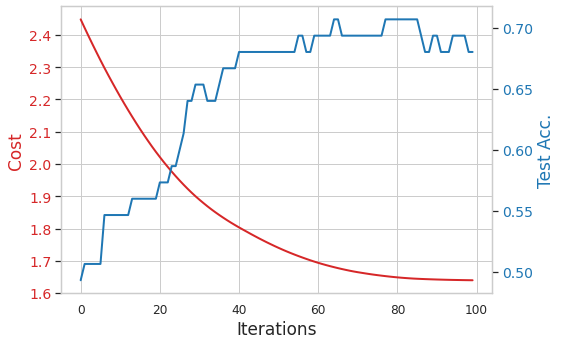

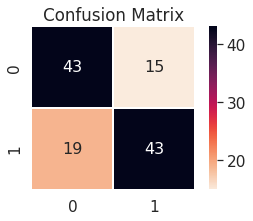

In [ ]:
# Initialize the weights and bias of the model layers
num_layers = 1
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

# train the classifier
train_classifier(X_train, Y_train, batch_size=170, total_iterations=100, learning_rate=0.01, weights=weights_init, bias=bias_init, num_train = num_train)

Iter:     1 | Cost: 2.7872177 | Acc train: 0.4933333 | Acc validation: 0.4533333 
Iter:     2 | Cost: 2.7545947 | Acc train: 0.4933333 | Acc validation: 0.4533333 
Iter:     3 | Cost: 2.7218003 | Acc train: 0.5022222 | Acc validation: 0.4533333 
Iter:     4 | Cost: 2.6886461 | Acc train: 0.4977778 | Acc validation: 0.4533333 
Iter:     5 | Cost: 2.6553145 | Acc train: 0.5066667 | Acc validation: 0.4533333 
Iter:     6 | Cost: 2.6218152 | Acc train: 0.5066667 | Acc validation: 0.4533333 
Iter:     7 | Cost: 2.5879778 | Acc train: 0.5066667 | Acc validation: 0.4533333 
Iter:     8 | Cost: 2.5540761 | Acc train: 0.5155556 | Acc validation: 0.4533333 
Iter:     9 | Cost: 2.5199485 | Acc train: 0.5288889 | Acc validation: 0.4666667 
Iter:    10 | Cost: 2.4858517 | Acc train: 0.5333333 | Acc validation: 0.4666667 
Iter:    11 | Cost: 2.4518894 | Acc train: 0.5466667 | Acc validation: 0.4666667 
Iter:    12 | Cost: 2.4181234 | Acc train: 0.5555556 | Acc validation: 0.4666667 
Iter:    13 | Co

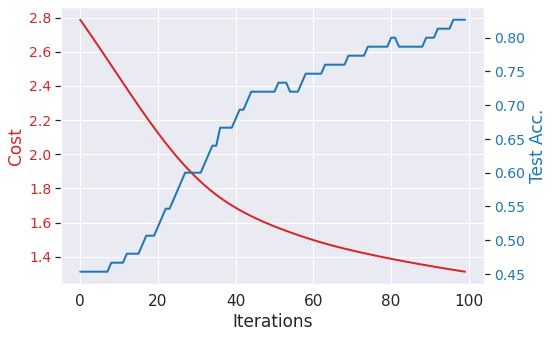

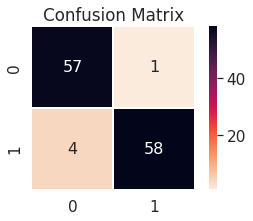

In [ ]:
# Initialize the weights and bias of the model layers
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

# train the classifier
train_classifier(X_train, Y_train, batch_size=170, total_iterations=100, learning_rate=0.01, weights=weights_init, bias=bias_init, num_train = num_train)

Iter:     1 | Cost: 2.2883329 | Acc train: 0.5777778 | Acc validation: 0.5466667 
Iter:     2 | Cost: 2.2366739 | Acc train: 0.5911111 | Acc validation: 0.5466667 
Iter:     3 | Cost: 2.1857684 | Acc train: 0.6000000 | Acc validation: 0.5466667 
Iter:     4 | Cost: 2.1349347 | Acc train: 0.6088889 | Acc validation: 0.5600000 
Iter:     5 | Cost: 2.0846204 | Acc train: 0.6266667 | Acc validation: 0.5733333 
Iter:     6 | Cost: 2.0349689 | Acc train: 0.6444444 | Acc validation: 0.5866667 
Iter:     7 | Cost: 1.9859783 | Acc train: 0.6622222 | Acc validation: 0.6133333 
Iter:     8 | Cost: 1.9375554 | Acc train: 0.6711111 | Acc validation: 0.6533333 
Iter:     9 | Cost: 1.8898660 | Acc train: 0.6711111 | Acc validation: 0.6666667 
Iter:    10 | Cost: 1.8429678 | Acc train: 0.6711111 | Acc validation: 0.6666667 
Iter:    11 | Cost: 1.7971710 | Acc train: 0.6844444 | Acc validation: 0.6800000 
Iter:    12 | Cost: 1.7526434 | Acc train: 0.6933333 | Acc validation: 0.6800000 
Iter:    13 | Co

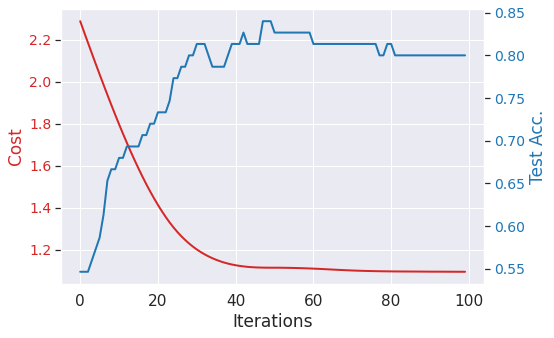

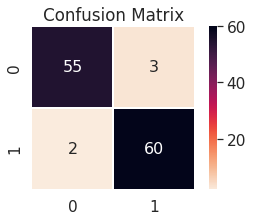

In [ ]:
# Initialize the weights and bias of the model layers
num_layers = 3
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

# train the classifier
train_classifier(X_train, Y_train, batch_size=170, total_iterations=100, learning_rate=0.01, weights=weights_init, bias=bias_init, num_train = num_train)

# Result Analysis and Discussion

It is observed that with an increase in the number of layers in the variational classifier, there is an increase in the classification performance with a smoother convergence. The performance gain saturates at the third layer, with the best performance of $95.83\%$.

For the optimizer in use, Adam, a learning rate of $0.1$ leads to a faster initial convergence while the performance is unstable and saturates quickly.

With a learning rate of $0.01$, the classifier has a slower but smoother convergence and a stable performance gain.